In [1]:
import numpy as np
from tqdm import tqdm
import os
import cv2

In [2]:
def calculate_label(img_basename):
    tmp = img_basename[:len(img_basename)-4].split("_")
    row = tmp[2]
    rod_id = int(tmp[3])
    if row in {"A", "B", "E", "F", "I", "J"}:
        label = 4-(rod_id % 4)
    else:
        label = (rod_id % 4)+1
    return label

In [3]:
make_dataset = False

class datasetProduct():
    path = "QR_d_best"
    images = list()
    labels = list()
    image_size = 64
    
    number_counter = {i:0 for i in range(1, 5)}
    total_number = 0
    
    def production(self):
        for img_basename in tqdm(os.listdir(self.path)):
            if "jpg" in img_basename:
                try:
                    img = cv2.imread(os.path.join(self.path, img_basename), cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.image_size, self.image_size))
                    img = np.array(img)
                    self.images.append((img))
                    label_img = calculate_label(img_basename)
                    self.number_counter[label_img] += 1
                    self.total_number += 1
                    self.labels.append(np.eye(4)[label_img - 1])
                    #print(img.shape)
                except Exception as e:
                    print(e)
        
        #print(self.images)
        #print(self.labels)
        img_with_labels = list(zip(self.images, self.labels))
        np.random.shuffle(img_with_labels)
        self.images, self.labels = zip(*img_with_labels)
        
        np.save('images.npy', self.images)
        np.save('lables.npy', self.labels)
if make_dataset: 
    datasets = datasetProduct()
    datasets.production()

In [4]:
print(datasets.number_counter)

NameError: name 'datasets' is not defined

In [ ]:
print(datasets.total_number)

4320


In [ ]:
images = np.load("images.npy", allow_pickle=True)
labels = np.load("lables.npy", allow_pickle=True)

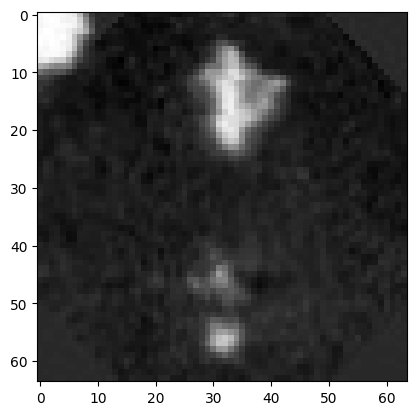

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images[3], cmap="gray")
plt.show()

In [ ]:
print(labels[3])

[0. 0. 0. 1.]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
if torch.cuda.is_available():
    device = "cuda:0"
    print("Running on GPU")
else:
    device = "cpu"
    print("Running on CPU")

Running on GPU


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 7)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.conv4 = nn.Conv2d(128, 256, 3)
        
        x = torch.randn((1, 64, 64))
        self._to_linear = None
        
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, 4)
        
    def convs(self, X):
        X = F.max_pool2d(F.relu(self.conv1(X)), (2, 2))
        X = F.max_pool2d(F.relu(self.conv2(X)), (2, 2))
        X = F.max_pool2d(F.relu(self.conv3(X)), (2, 2))
        X = F.max_pool2d(F.relu(self.conv4(X)), (2, 2))
        if self._to_linear is None:
            self._to_linear = X.shape[0] * X.shape[1] * X.shape[2]
            
        return X
    
    def forward(self, X):
        X = self.convs(X)
        X = X.view(-1, self._to_linear)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        
        return X
    
num_recognition = Net().to(device)
print(num_recognition)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)


In [ ]:
images = torch.tensor(images).view(-1, 1, 64, 64)
images = images / 255.0
labels = torch.tensor(labels)

print(images.shape)
print(labels.shape)

torch.Size([4320, 1, 64, 64])
torch.Size([4320, 4])


In [ ]:
test_dataset_size = int(0.1 * len(images))
split_point = len(images) - test_dataset_size
print(test_dataset_size)
print(split_point)
train_X = images[:split_point]
train_y = labels[:split_point]

test_X = images[split_point:]
test_y = labels[split_point:]

print(len(train_X))
print(len(test_X))

432
3888
3888
432


In [ ]:
len(images)

4320

In [ ]:
print(test_X.size())
print(test_y.size())

torch.Size([432, 1, 64, 64])
torch.Size([432, 4])


In [ ]:
train_y.type

<function Tensor.type>

In [ ]:
test_y.ndim

2

In [ ]:
test_y[0:100].to(device)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1.,

In [ ]:
train_y[0:100]

tensor([[0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0.,

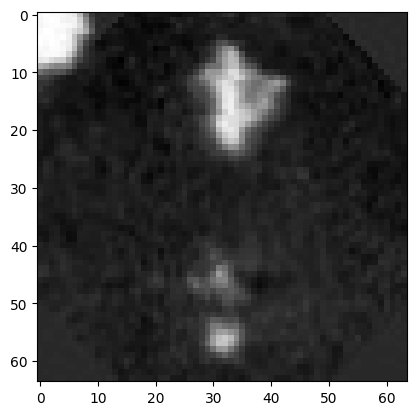

In [ ]:
plt.imshow(train_X[3].view(64, 64), cmap="gray")

In [ ]:
train_y[3]

tensor([0., 0., 0., 1.], dtype=torch.float64)

In [ ]:
optimizer = optim.Adam(num_recognition.parameters(), lr=0.001)
loss_function  = nn.CrossEntropyLoss()
batch_size = 100
epochs = 10

def train(num_recognition):
    for epoch in range(epochs):
        for i in tqdm(range(0, len(train_X), batch_size)):
            batch_x = train_X[i:i+batch_size].view(-1, 1, 64, 64).float()
            batch_y = train_y[i:i+batch_size].float()
            
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            num_recognition.zero_grad()
            output = num_recognition(batch_x)
            #print(output.shape)
            #print(output[0])
            loss = loss_function(output, batch_y)
            loss.backward()
            optimizer.step()
        
        print(f"epoch: {epoch}, loss: {loss}")
            
train(num_recognition)

100%|██████████| 39/39 [00:00<00:00, 99.85it/s]


epoch: 0, loss: 1.3491171598434448


100%|██████████| 39/39 [00:00<00:00, 108.70it/s]


epoch: 1, loss: 1.2125053405761719


100%|██████████| 39/39 [00:00<00:00, 105.65it/s]


epoch: 2, loss: 0.9559439420700073


100%|██████████| 39/39 [00:00<00:00, 105.85it/s]


epoch: 3, loss: 0.43873468041419983


100%|██████████| 39/39 [00:00<00:00, 107.07it/s]


epoch: 4, loss: 0.2620113492012024


100%|██████████| 39/39 [00:00<00:00, 106.74it/s]


epoch: 5, loss: 0.23478664457798004


100%|██████████| 39/39 [00:00<00:00, 107.58it/s]


epoch: 6, loss: 0.12253200262784958


100%|██████████| 39/39 [00:00<00:00, 107.40it/s]


epoch: 7, loss: 0.07717698812484741


100%|██████████| 39/39 [00:00<00:00, 106.95it/s]


epoch: 8, loss: 0.03968777135014534


100%|██████████| 39/39 [00:00<00:00, 107.81it/s]

epoch: 9, loss: 0.054035358130931854


In [ ]:
test_X[1].shape
ret = num_recognition(test_X[1].to(device))
torch.argmax(ret)

tensor(1, device='cuda:0')

In [ ]:
torch.argmax(test_y[1])

tensor(1)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(0, len(test_X))):
        output = num_recognition(test_X[i].to(device))
        
        predicted_class = torch.argmax(output)
        true_class = torch.argmax(test_y[i])
        
        if predicted_class == true_class:
            correct += 1
        total += 1

print(f"Accuracy: {round(correct/total, 3)}")
print(correct)

100%|██████████| 432/432 [00:00<00:00, 2790.51it/s]

Accuracy: 0.979
423


In [ ]:
a = torch.tensor([1, 0, 0])
torch.argmax(a)

tensor(0)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(0, len(train_X))):
        output = num_recognition(train_X[i].to(device))
        
        predicted_class = torch.argmax(output)
        true_class = torch.argmax(train_y[i])
        
        if predicted_class == true_class:
            correct += 1
        total += 1

print(f"Accuracy: {round(correct/total, 3)}")
print(correct)

100%|██████████| 3888/3888 [00:01<00:00, 2848.56it/s]

Accuracy: 0.985
3831


In [ ]:
torch.save(num_recognition.state_dict(), "num_recognition.pth")


In [ ]:
num_recognition.load_state_dict(torch.load("num_recognition.pth"))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(0, len(test_X))):
        output = num_recognition(test_X[i].to(device))
        
        predicted_class = torch.argmax(output)
        true_class = torch.argmax(test_y[i])
        
        if predicted_class == true_class:
            correct += 1
        total += 1

print(f"Accuracy: {round(correct/total, 3)}")
print(correct)

100%|██████████| 432/432 [00:00<00:00, 2995.22it/s]

Accuracy: 0.979
423


In [ ]:
metrics = {1:{"TP":0, "FP":0, "FN":0}, 2:{"TP":0, "FP":0, "FN":0}, 3:{"TP":0, "FP":0, "FN":0}, 4:{"TP":0, "FP":0, "FN":0}}

batch_size = 100
correct = 0
with torch.no_grad():
    for i in tqdm(range(0, len(test_X), batch_size)):
        output = num_recognition(test_X[i:i+batch_size].view(-1, 1, 64, 64).to(device))
        true_class = test_y[i:i+batch_size].to(device)
        for j in range(len(output)):
            predicted = torch.argmax(output[j])
            true_label = torch.argmax(true_class[j])
            if predicted == true_label:
                correct += 1
                metrics[int(predicted)+1]["TP"] += 1
            else:
                 metrics[int(predicted)+1]["FP"] += 1
                 metrics[int(true_label)+1]["FN"] += 1
                
print(metrics)


100%|██████████| 5/5 [00:00<00:00, 127.22it/s]

{1: {'TP': 109, 'FP': 7, 'FN': 1}, 2: {'TP': 118, 'FP': 0, 'FN': 1}, 3: {'TP': 103, 'FP': 1, 'FN': 2}, 4: {'TP': 93, 'FP': 1, 'FN': 5}}


In [ ]:
precision_per_class = {i:0 for i in range(1, 5)}
recall_per_class = {i:0 for i in range(1, 5)}

for group, met in metrics.items():
    precision_per_class[group] = round(met["TP"] / (met["TP"] + met["FP"]), 2)
    recall_per_class[group] = round(met["TP"] / (met["TP"] + met["FN"]), 2)
    
print(precision_per_class)
print(recall_per_class)

{1: 0.94, 2: 1.0, 3: 0.99, 4: 0.99}
{1: 0.99, 2: 0.99, 3: 0.98, 4: 0.95}


In [ ]:
overall_precision = sum(precision_per_class.values()) / len(precision_per_class)
overall_recall = sum(recall_per_class.values()) / len(recall_per_class)

print(overall_precision)
print(overall_recall)

0.98
0.9775


In [ ]:
F1_Score = 2 * ((overall_precision * overall_recall) / (overall_precision + overall_recall))
print(round(F1_Score, 2))

0.98
